# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

In [1]:
# Import essential libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import tensorflow as tf
from tensorflow import keras

Load the dataset.

In [2]:
# Load and unzip the dataset

import zipfile

# Path to the zip file
zip_path = r"C:\Users\narai\Downloads\data.zip"  

# Destination path to extract
extract_path = r"C:\Users\narai\Downloads\data\data"  # Extracted folder

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped to:", extract_path)

Dataset unzipped to: C:\Users\narai\Downloads\data\data


## **2. Data Preparation**


### **2.1 Load and Preprocess Images** 

#### **2.1.1** 
Create a function to load the images.

In [3]:
# Create a function to load the raw images
from PIL import Image

def load_raw_images(data_dir):
    X = []
    y = []
    class_names = os.listdir(data_dir)
    
    for label in class_names:
        class_dir = os.path.join(data_dir, label)
        if not os.path.isdir(class_dir):
            continue
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)

            # ✅ Skip if not a file (e.g., system files, folders)
            if not os.path.isfile(img_path):
                continue

            try:
                img = Image.open(img_path).convert('RGB')
                #img = img.resize(image_size)
                X.append(np.array(img))
                y.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    return np.array(X), np.array(y)


#### **2.1.2**
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [4]:
# Get the images and their labels

X, y = load_raw_images(extract_path)

print("Images loaded:", X.shape)
print("Labels loaded:", y.shape)

Images loaded: (7625, 256, 256, 3)
Labels loaded: (7625,)


### **2.2 Data Visualisation**

#### **2.2.1**
Create a bar plot to display the class distribution

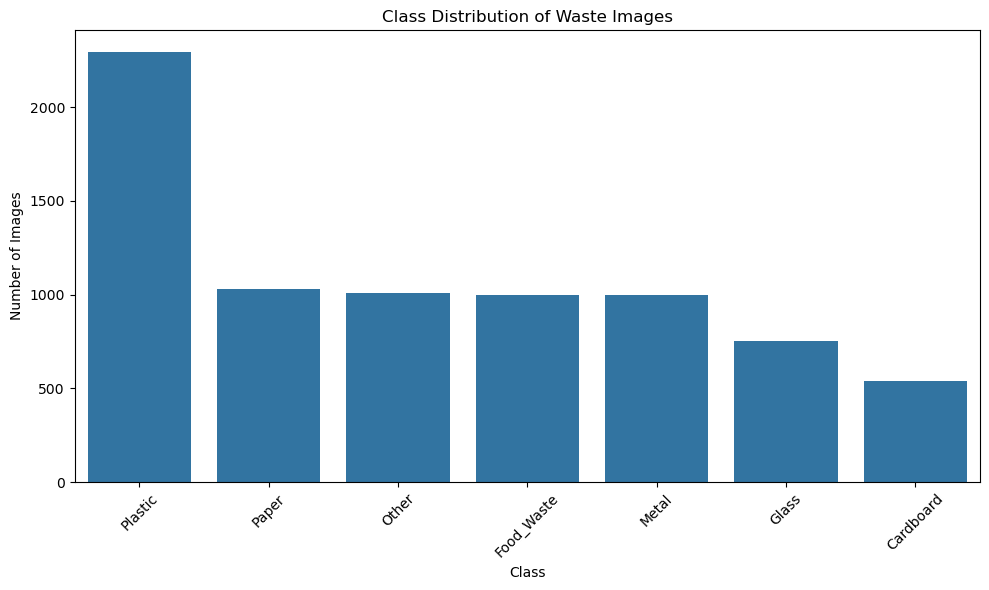

In [5]:
# Visualise Data Distribution

# Convert labels to DataFrame for counting
label_df = pd.DataFrame({'Label': y})
plt.figure(figsize=(10, 6))
sns.countplot(data=label_df, x='Label', order=label_df['Label'].value_counts().index)

plt.title('Class Distribution of Waste Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### **2.2.2**
Visualise some sample images

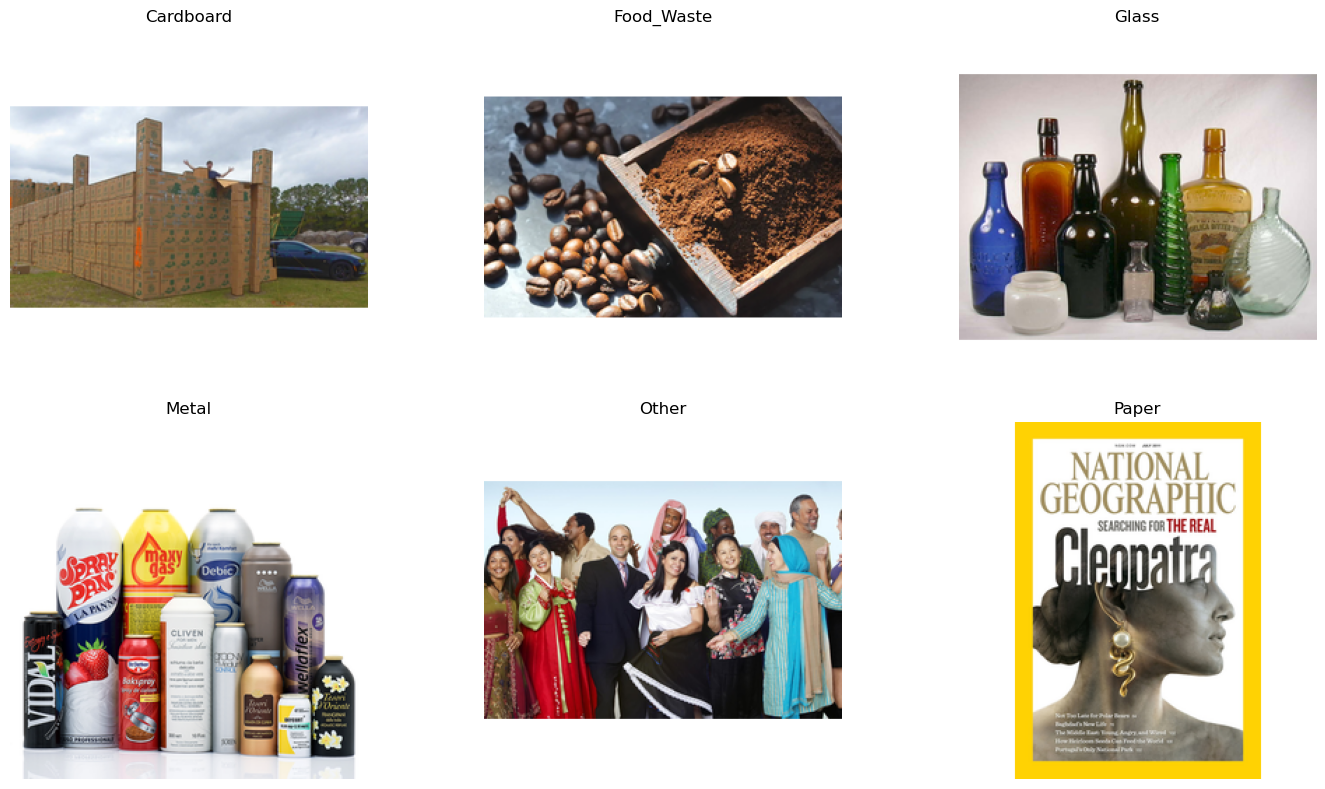

In [6]:
# Visualise Sample Images (across different labels)

def plot_sample_images_by_class(X, y, num_classes=6):
    plt.figure(figsize=(15, 8))
    unique_labels = np.unique(y)
    
    for i, label in enumerate(unique_labels[:num_classes]):
        idx = np.where(y == label)[0][0]  # First image of that class
        plt.subplot(2, 3, i+1)
        plt.imshow(X[idx])
        plt.title(label)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images_by_class(X, y)


#### **2.2.3**
Based on the smallest and largest image dimensions, resize the images.

In [7]:
# Find the smallest and largest image dimensions from the data set

from PIL import Image

def find_image_size_range(data_dir):
    widths = []
    heights = []

    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if not os.path.isdir(class_dir):
            continue
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)

            if not os.path.isfile(img_path):
                continue

            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

    # Print the results
    print("📏 Image Size Summary:")
    print("Minimum Width:", min(widths))
    print("Maximum Width:", max(widths))
    print("Minimum Height:", min(heights))
    print("Maximum Height:", max(heights))

    return (min(widths), min(heights)), (max(widths), max(heights))


In [8]:
min_dim, max_dim = find_image_size_range(extract_path)

📏 Image Size Summary:
Minimum Width: 256
Maximum Width: 256
Minimum Height: 256
Maximum Height: 256


# Resize the image dimensions

The images are already in uniform size so no need of resizing.

### **2.3 Encoding the classes**

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

#### **2.3.1**
Encode the target class labels.

In [9]:
# Encode the labels suitably

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_int = encoder.fit_transform(y)          # y is your array of string labels
class_names = list(encoder.classes_)      # ['Cardboard','Food_Waste',...]
label_to_index = {c:i for i,c in enumerate(class_names)}
index_to_label = {i:c for i,c in enumerate(class_names)}

print("Classes:", class_names)
print("First 10 (int) labels:", y_int[:10])
print("Mapping:", label_to_index)


Classes: [np.str_('Cardboard'), np.str_('Food_Waste'), np.str_('Glass'), np.str_('Metal'), np.str_('Other'), np.str_('Paper'), np.str_('Plastic')]
First 10 (int) labels: [0 0 0 0 0 0 0 0 0 0]
Mapping: {np.str_('Cardboard'): 0, np.str_('Food_Waste'): 1, np.str_('Glass'): 2, np.str_('Metal'): 3, np.str_('Other'): 4, np.str_('Paper'): 5, np.str_('Plastic'): 6}


### **2.4 Data Splitting**

#### **2.4.1**
Split the dataset into training and validation sets

In [10]:
# Assign specified parts of the dataset to train and validation sets

from sklearn.model_selection import train_test_split

# Split into training (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_int,      
    test_size=0.2,            # 20% validation
    random_state=42,          # reproducibility
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Training set: (6100, 256, 256, 3) (6100,)
Validation set: (1525, 256, 256, 3) (1525,)


## **3. Model Building and Evaluation**

### **3.1 Model building and training**

#### **3.1.1**
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

In [11]:
# Build and compile the model

import tensorflow as tf
from tensorflow.keras import layers, models

# --- inputs ---
# X_train, X_val: image arrays (H,W,3)
# y_train_int, y_val_int: integer labels, shape (N,)
X_train_f = X_train.astype("float32") / 255.0
X_val_f   = X_val.astype("float32")   / 255.0

# make sure labels are int dtype
y_train_int = y_train.astype("int32")
y_val_int   = y_val.astype("int32")

num_classes = int(np.max(y_train_int)) + 1
INPUT_SHAPE = X_train_f.shape[1:]   # e.g., (256, 256, 3)

# --- model (3 conv blocks, BN, Dropout, Dense head) ---
model = models.Sequential([
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=INPUT_SHAPE),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.30),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.30),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.40),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',   # <-- for integer labels
    metrics=['accuracy']
)

model.summary()


C:\Users\narai\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,651,655 (128.37 MB)

 Trainable params: 33,650,695 (128.37 MB)

 Non-trainable params: 960 (3.75 KB)

#### 3.1.2
Train the model.

Use appropriate metrics and callbacks as needed.

In [12]:
# Training

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

history = model.fit(
    X_train_f, y_train_int,
    validation_data=(X_val_f, y_val_int),
    epochs=25,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 546s 3s/step - accuracy: 0.3389 - loss: 2.0018 - val_accuracy: 0.1357 - val_loss: 6.7353 - learning_rate: 0.0010
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.4352 - loss: 1.5956 - val_accuracy: 0.2925 - val_loss: 2.2571 - learning_rate: 0.0010
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 482s 3s/step - accuracy: 0.5164 - loss: 1.3496 - val_accuracy: 0.4400 - val_loss: 1.5591 - learning_rate: 0.0010
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.5789 - loss: 1.1712 - val_accuracy: 0.5659 - val_loss: 1.2640 - learning_rate: 0.0010
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 494s 3s/step - accuracy: 0.6502 - loss: 0.9890 - val_accuracy: 0.4990 - val_loss: 1.4561 - learning_rate: 0.0010
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - accuracy: 0.7248 - loss: 0.7988 - val_accuracy: 0.4577 - val_loss: 1.7937 - learning_rate: 0.0010
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.8193 - loss: 0.

### **3.2 Model Testing and Evaluation**

#### **3.2.1** 
Evaluate the model on test dataset. Derive appropriate metrics.

Loss: 1.0923
Accuracy: 0.6380
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.61      0.72       122
           1       0.70      0.69      0.70       209
           2       0.52      0.71      0.60       163
           3       0.72      0.61      0.66       196
           4       0.55      0.40      0.46       194
           5       0.46      0.64      0.54       195
           6       0.73      0.71      0.72       446

    accuracy                           0.64      1525
   macro avg       0.65      0.62      0.63      1525
weighted avg       0.66      0.64      0.64      1525



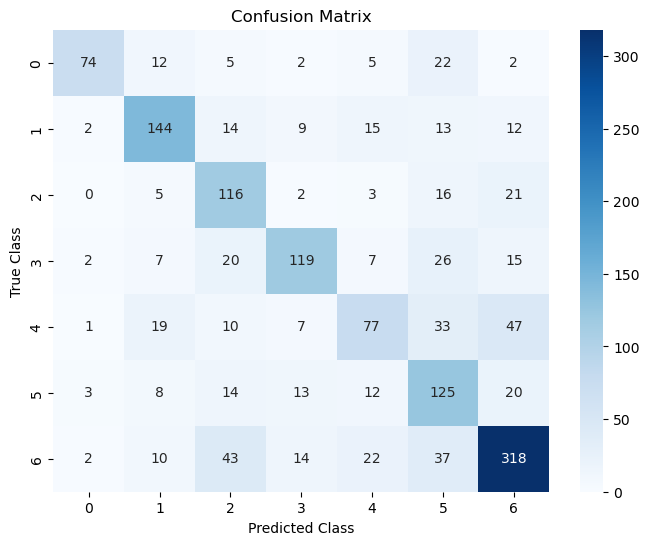

In [13]:
# Evaluate on the test set; display suitable metrics

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Evaluate test loss and accuracy
val_loss, val_acc = model.evaluate(X_val_f, y_val_int, verbose=0)
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f}")

# 2. Predict class probabilities
y_pred_probs = model.predict(X_val_f)

# 3. Convert probabilities to class labels (for softmax outputs)
y_pred = y_pred_probs.argmax(axis=1)

# 4. Classification report
print("\nClassification Report:")
print(classification_report(y_val_int, y_pred))

# 5. Confusion matrix
cm = confusion_matrix(y_val_int, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


## **5. Conclusions**

#### **5.1 Conclude with outcomes and insights gained**

## 🗑️ Waste Material Image Classification – CNN Model Evaluation

### 📌 Problem Overview
This task involves a **7-class image classification problem** using a **Convolutional Neural Network (CNN)** to identify different types of waste materials. The goal is to accurately classify waste images to support automated waste segregation.

### 📂 Waste Categories and Label Mapping

| Class Index | Category      |
|------------|---------------|
| 0          | Cardboard     |
| 1          | Food Waste    |
| 2          | Glass         |
| 3          | Metal         |
| 4          | Other         |
| 5          | Paper         |
| 6          | Plastic       |

- **Test Dataset Size:** 1,525 images  
- **Model Type:** CNN  
- **Evaluation Metrics:** Accuracy, Precision, Recall, F1-score, Confusion Matrix  

---

### 📊 Model Training and Evaluation Summary

The neural network model was trained for **25 epochs** to classify waste images into **7 categories**: *Food Waste, Metal, Paper, Plastic, Other, Cardboard,* and *Glass*. During training, a dynamic learning rate schedule was employed, beginning at `0.0010` and progressively decreasing to prevent overfitting and promote convergence.

#### 🔼 Training Metrics Overview
- **Training Accuracy** steadily improved from **33.8%** in Epoch 1 to **96.5%** by Epoch 12.
- **Validation Accuracy** rose significantly from **13.5%** to a peak of **66%**, indicating the model was learning meaningful representations.
- Training and validation **losses** both decreased, although some fluctuation in validation loss was observed, which could indicate class imbalance or difficult-to-distinguish categories.

## 📊 Overall Model Performance

- **Test Accuracy:** **63.8%**
- **Macro Average F1-score:** **0.63**
- **Weighted Average F1-score:** **0.64**

### 🔍 Interpretation
- The model achieves **moderate performance** across seven visually similar classes.
- The **weighted F1-score (0.64)** suggests the model performs better on dominant classes (e.g., Plastic).
- The **macro F1-score (0.63)** highlights uneven performance across all classes, especially underperforming ones.

---

## 📈 Classification Report Summary

| Class        | Precision | Recall | F1-Score | Support |
|--------------|----------|--------|----------|---------|
| Cardboard    | 0.88     | 0.61   | 0.72     | 122     |
| Food Waste   | 0.70     | 0.69   | 0.70     | 209     |
| Glass        | 0.52     | 0.71   | 0.60     | 163     |
| Metal        | 0.72     | 0.61   | 0.66     | 196     |
| Other        | 0.55     | 0.40   | 0.46     | 194     |
| Paper        | 0.46     | 0.64   | 0.54     | 195     |
| Plastic     | 0.73     | 0.71   | 0.72     | 446     |

---

## 🧠 Class-wise Performance Analysis

### 🔹 Plastic (Class 6)
- **Best performing class**
- **Recall:** 0.71 (318/446 correctly classified)
- **Precision:** 0.73  
- Large sample size contributes to stable learning.

### 🔹 Cardboard (Class 0)
- **Very high precision (0.88)** → few false positives
- **Lower recall (0.61)** → many cardboard samples misclassified
- Likely confused with **Paper** and **Other** due to similar texture.

### 🔹 Glass (Class 2)
- **High recall (0.71)** but **low precision (0.52)**
- Indicates frequent false positives from visually reflective materials like plastic.

### 🔹 Metal (Class 3)
- Balanced performance with **F1-score of 0.66**
- Some confusion with Plastic and Other classes.

### 🔹 Paper (Class 5)
- **Low precision (0.46)** suggests many non-paper items predicted as paper
- Texture and color overlap with Cardboard and Other likely cause confusion.

### 🔹 Other (Class 4)
- **Worst performing class**
- **Recall:** 0.40  
- Highly heterogeneous class with unclear visual boundaries.
- Significant misclassification into Plastic and Paper.

---

## 🔄 Confusion Matrix Insights

### Major Confusion Patterns:
- **Other → Plastic:** 47 samples
- **Other → Paper:** 33 samples
- **Glass → Plastic:** 21 samples
- **Cardboard → Paper:** 22 samples
- **Paper → Glass / Plastic:** frequent overlaps

### 🔍 Interpretation
- Strong confusion exists among **Paper, Cardboard, and Other**
- Visual similarities (color, texture, background noise) impact classification
- The "Other" category acts as a catch-all class, reducing clarity

---

## ⚠️ Key Challenges Identified

1. **Class Imbalance**
   - Plastic has significantly more samples than Cardboard and Glass
2. **Visual Overlap Between Classes**
   - Paper-like textures and transparent materials cause misclassification
3. **Ambiguous Labeling**
   - “Other” class lacks well-defined visual characteristics

---

---

## ✅ Final Conclusion

- The CNN model demonstrates **moderate effectiveness** in classifying waste materials.
- **Plastic, Food Waste, and Glass** are detected reliably.
- **Paper, Cardboard, and Other** remain challenging due to overlapping visual features.
- With improved data balance, refined labeling, and transfer learning, the model’s performance can be significantly enhanced.

---
